##Library and PyPI

In [1]:
# Install
!pip install geopandas
!pip install country_converter
!pip install geoplot
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install tueplots

     |████████████████████████████████| 1.0 MB 4.6 MB/s 
     |████████████████████████████████| 15.4 MB 44.9 MB/s 
     |████████████████████████████████| 6.3 MB 32.8 MB/s 
     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.4-py3-none-any.whl size=53543 sha256=318c8aad72432437d03e8774614e81b2874ac050d32d5448d0c4c28fd9925d26
  Stored in directory: /root/.cache/pip/wheels/69/cf/84/9ebca78737327440a0bb5faa6d0380e9017730534cf0dbcb8c
Successfully built country-converter
     |████████████████████████████████| 10.8 MB 9.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 15.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 25.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |█████

In [2]:
# library
import numpy as np
import pandas as pd
import geopandas as geo
import geoplot as gplt
import matplotlib.pyplot as plt
import country_converter as coco
import seaborn as sns
from tueplots import bundles
# plt.rcParams.update(bundles.neurips2021(usetex=False))


##Data Preprocessing

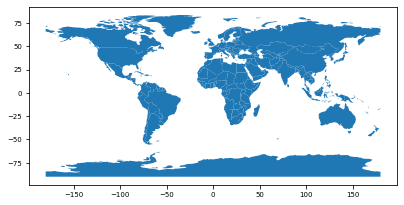

In [5]:
# load data into the dataset
dataset = pd.read_csv("https://salaries.freshremote.work/download/salaries.csv")

#see what world dataset are available
geo.datasets.available

# get information from world and city
world = geo.read_file(geo.datasets.get_path('naturalearth_lowres'))
# cities = geo.read_file(geo.datasets.get_path('naturalearth_cities'))
# nybb = geo.read_file(geo.datasets.get_path('nybb'))
world.plot()

In [14]:
# dataset has iso in type 2 and world in type 3
# convert them to the ISO3
converter = coco.CountryConverter()
iso3 = converter.convert(names = dataset.company_location, src = 'ISO2', to = 'ISO3')
dataset = dataset.replace(dataset.company_location.to_list(), iso3)

In [15]:
# County ISOs
dataset_isos = dataset.company_location.unique()
world_isos = world.iso_a3.unique()

# Find ISOs only in one of the two county ISO sets
unmatched_isos = np.setxor1d(dataset_isos, world_isos) #-----> difference
print(f"Countries in the company location but not in the world: \n{dataset[dataset.company_location.isin(unmatched_isos)].company_location.unique()}")


Countries in the company location but not in the world: 
['SGP' 'FRA' 'NOR' 'UMI' 'MLT' 'ASM']


In [17]:
#Nor and Fra only have code -99
world.loc[21,'iso_a3'] = 'NOR' 
world.loc[43,'iso_a3'] = 'FRA' 

# delete 'SGP' and 'MLT' rows
dataset = dataset.drop(dataset[dataset.company_location == 'SGP'].index)
dataset = dataset.drop(dataset[dataset.company_location == 'MLT'].index)

# change iso code 'UMI', 'ASM' to 'USA'
dataset = dataset.replace(['UMI', 'ASM'],'USA')

##Choropleth map

### Remote working vs Location 2020


In [20]:
# take the average of remote ratio over countries
# we only care about the company location and the work year
dataset_remote = (
    dataset.groupby(["company_location","work_year"])
    .mean()
    .reset_index()
)


In [22]:
# Merge into single data frame
dataset_remote_geo = dataset_remote.merge(
    world, how="inner", left_on="company_location", right_on="iso_a3"
)
dataset_remote_geo.drop(
    dataset_remote_geo.columns.difference(
        ["name","company_location", "salary_in_usd", "remote_ratio", "pop_est", "geometry",'work_year','continent','gdp_md_est']
    ),
    1,
    inplace=True,
)
display(dataset_remote_geo.head())

,company_location,work_year,salary_in_usd,remote_ratio,pop_est,continent,name,gdp_md_est,geometry
0,AFG,2021e,2000.0,100.00,34124811,Asia,Afghanistan,64080.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
1,ARG,2020,31000.0,75.00,44293293,South America,Argentina,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
2,ARG,2021e,90000.0,50.00,44293293,South America,Argentina,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
3,ARM,2021e,36000.0,50.00,3045191,Asia,Armenia,26300.0,"POLYGON ((46.50572 38.77061, 46.14362 38.74120..."
4,AUS,2020,89852.5,81.25,23232413,Oceania,Australia,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


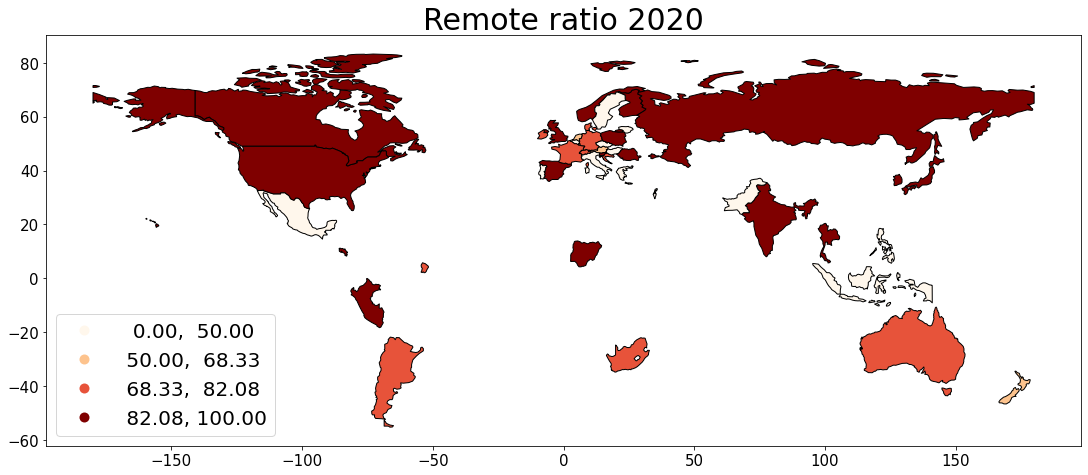

In [45]:
# the world map 2020
# Plot map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.rcParams.update({'font.size': 40})
geo_2020 = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.work_year == '2020'])
geo_2020.plot(
    column="remote_ratio",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    vmin=0.,
    cmap='OrRd', 
    k=5,
    scheme='quantiles',
    edgecolor='black',   
)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Remote ratio 2020',fontsize=30)
plt.rc('legend', fontsize=10)
plt.savefig('remote_ratio_world_map_2020.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


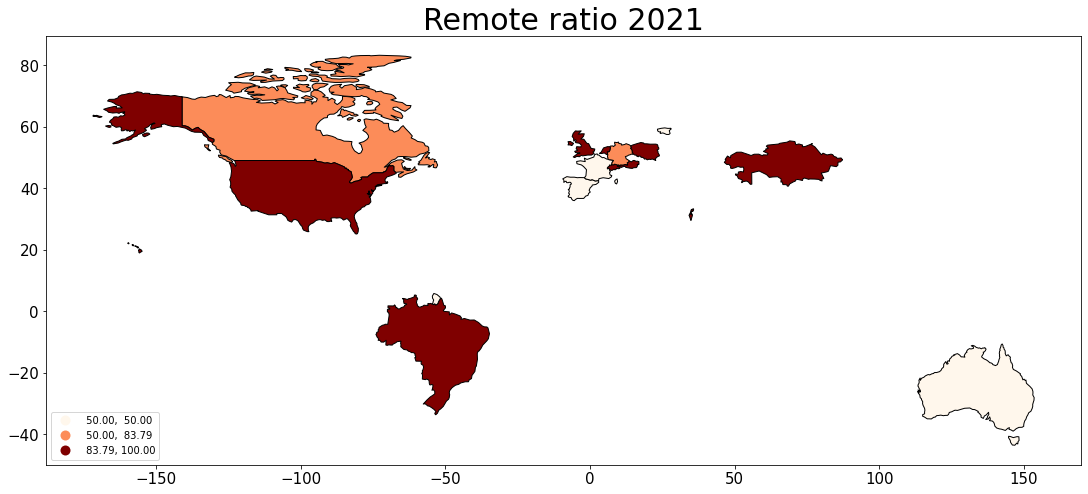

In [46]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.rcParams.update({'font.size': 40})
geo_2021 = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.work_year == '2021'])
geo_2021.plot(
    column="remote_ratio",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    vmin=0.,
    cmap='OrRd', 
    k=5,
    scheme='quantiles',
    edgecolor='black',   
)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Remote ratio 2021',fontsize=30)
plt.rc('legend', fontsize=10)
plt.savefig('remote_ratio_world_map_2021.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


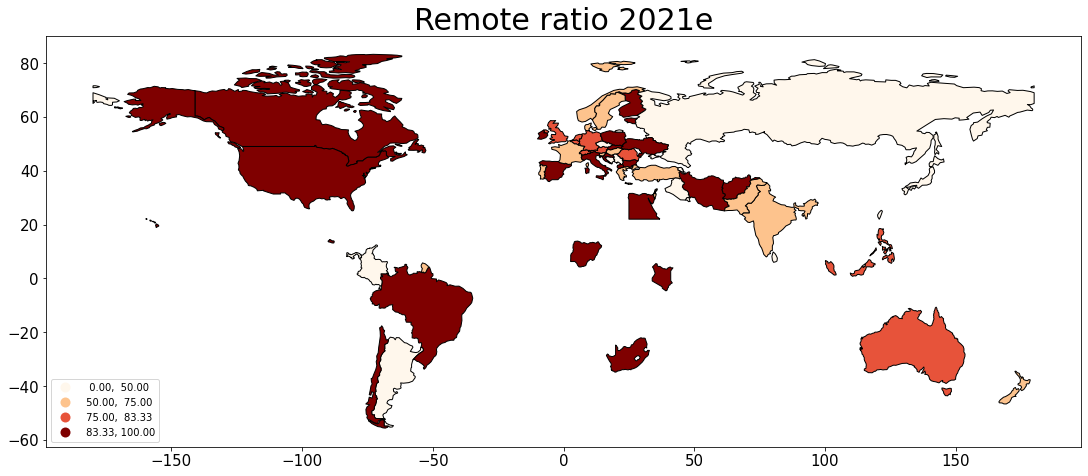

In [47]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.rcParams.update({'font.size': 40})
geo_2021e = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.work_year == '2021e'])
geo_2021e.plot(
    column="remote_ratio",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    vmin=0.,
    cmap='OrRd', 
    k=5,
    scheme='quantiles',
    edgecolor='black',   
)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Remote ratio 2021e',fontsize=30)
plt.rc('legend', fontsize=10)
plt.savefig('remote_ratio_world_map_2021e.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


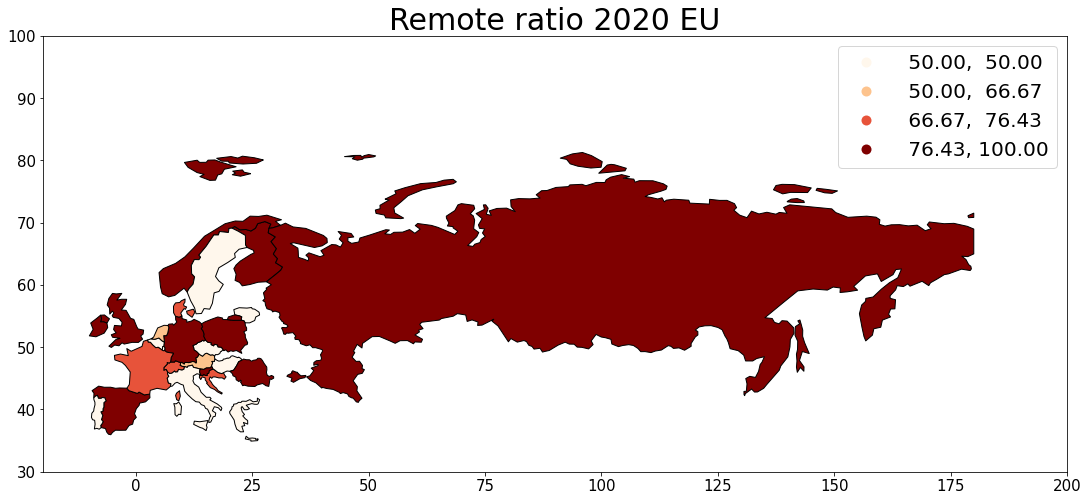

In [51]:

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.rcParams.update({'font.size': 40})
geo_2020_eu = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.work_year == '2020'][dataset_remote_geo.continent == "Europe"])
geo_2020_eu.plot(
    column="remote_ratio",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'upper right'},
    vmin=0.,
    cmap='OrRd', 
    k=5,
    scheme='quantiles',
    edgecolor='black',   
)
minx, miny, maxx, maxy = -20, 30, 200,100 
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Remote ratio 2020 EU',fontsize=30)
plt.rc('legend', fontsize=20)
plt.savefig('remote_ratio_world_map_2020_eu.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


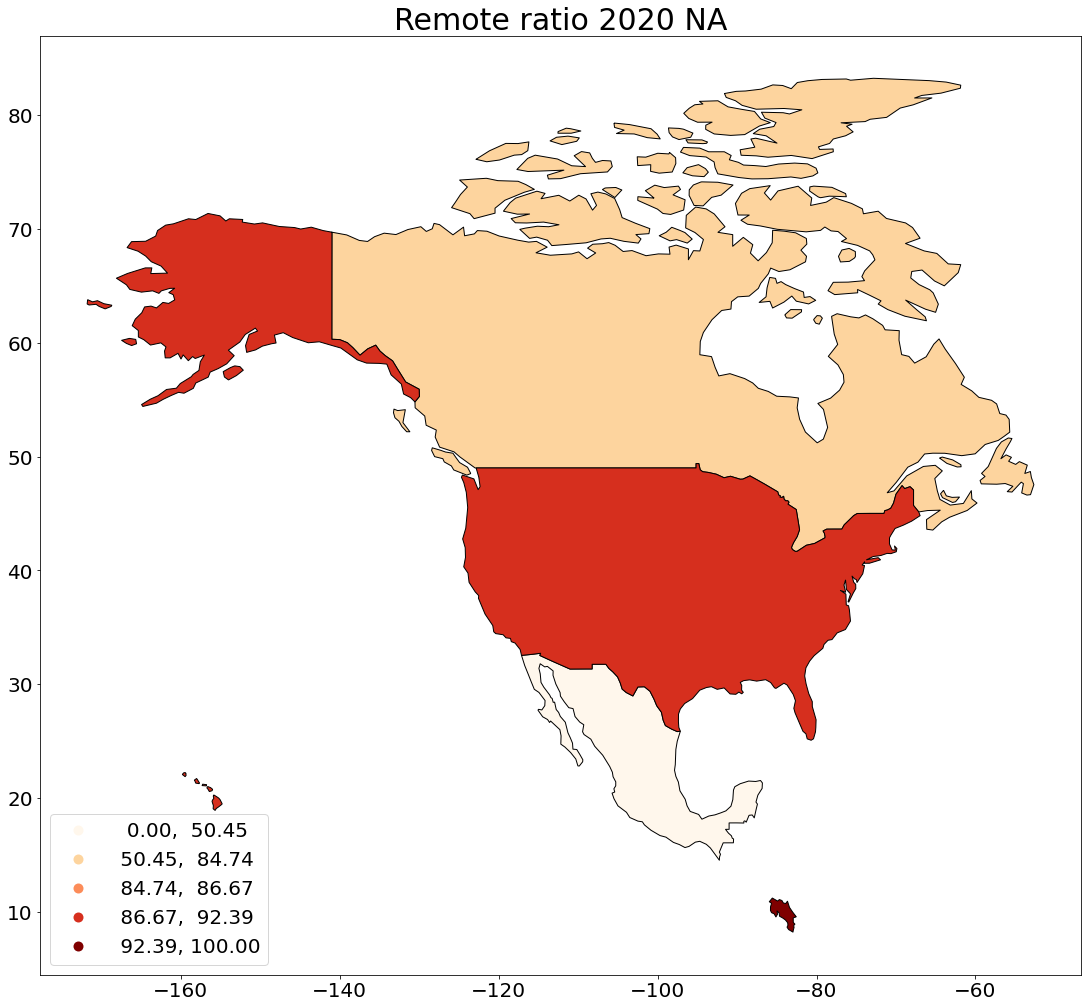

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.rcParams.update({'font.size': 40})
geo_2020_na = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.work_year == '2020'][dataset_remote_geo.continent == "North America"])
geo_2020_na.plot(
    column="remote_ratio",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    vmin=0.,
    cmap='OrRd', 
    k=5,
    scheme='quantiles',
    edgecolor='black',   
)
# minx, miny, maxx, maxy = -20, 30, 200,100 
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)
ax.tick_params(axis='both', labelsize=20)
ax.set_title('Remote ratio 2020 NA',fontsize=30)
plt.rc('legend', fontsize=20)
plt.savefig('remote_ratio_world_map_2020_na.png')
plt.show()